In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func, compartment_restrainer, weighted_quantile
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import os
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

from sbi.inference import infer
import sbi.utils as utils
import torch
from torch.distributions.multivariate_normal import MultivariateNormal


# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


## Reference trajectory

In [2]:
# Make up some populations (take as known)
M = 3
np.random.seed(0)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)
population_fraction = population/np.sum(population)
print (np.sum(population))

# compartment parameters
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 7, 3)
tmat.add_transition('A', 'I', 5, 3)
tmat.add_transition('I', 'R', 14, 4)

[4241. 3868. 1023.] [144101. 110004. 124468.]
378573.0


In [3]:
# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# start[0,0] = 0.1
# start[0,3] = 0.01
# start[0,1] = 0.2
start[0,2] = 0.02
start[0,1] = 0.05
np.random.seed(0)
# R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = np.array([[1000, 400, 10],
             [0, 300, 300],
             [300, 300, 1000]])
R_norm = R / np.sum(R, axis=1)
print (R_norm)
print(tmat.value)

[[0.70921986 0.66666667 0.00625   ]
 [0.         0.5        0.1875    ]
 [0.21276596 0.5        0.625     ]]
[[0.85714286 0.14285714 0.         0.        ]
 [0.         0.8        0.2        0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


In [4]:
infect_fxn = maxentep.contact_infection_func(infections_compartments)
timesteps = 250
model = maxentep.MetaModel(infect_fxn, timesteps, populations=population_fraction)
ref_traj = model(R_norm, tmat.value, start, 0.025)[0]
print (ref_traj.shape)

(250, 3, 5)


In [5]:
# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# start[0,0] = 0.1
# start[0,3] = 0.01
# start[0,1] = 0.2
start[0,2] = 0.02
start[0,1] = 0.05
np.random.seed(0)
# R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = np.array([[1000, 400, 10],
             [0, 300, 300],
             [300, 300, 1000]])
R_norm = R / np.sum(R, axis=1)
print (R_norm)
print(tmat.value)

[[0.70921986 0.66666667 0.00625   ]
 [0.         0.5        0.1875    ]
 [0.21276596 0.5        0.625     ]]
[[0.85714286 0.14285714 0.         0.        ]
 [0.         0.8        0.2        0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


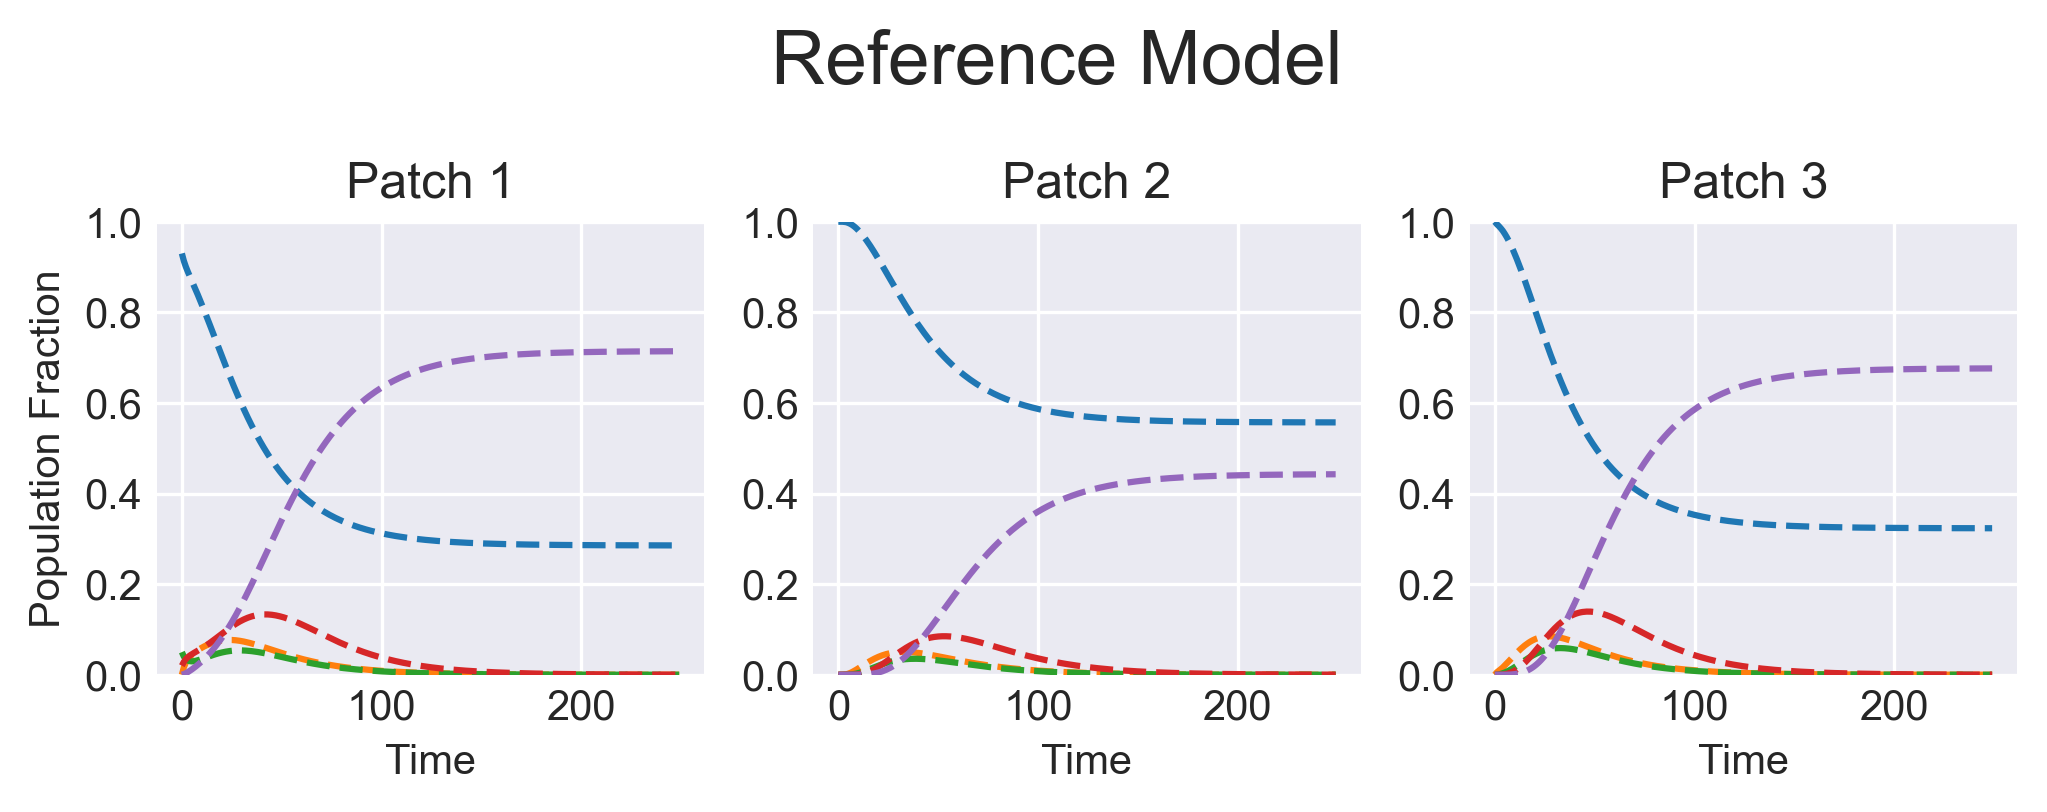

(3, 4)


In [6]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Reference Model', y = 1.2, fontsize = 18)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()
# print (tf.reduce_sum(ref_traj[:,0,:],axis=-1))
print (start.shape)

## Restraints

In [7]:
npoints = 5
np.random.seed(0)
# prior = maxentep.EmptyPrior()
prior = maxentep.Laplace(0.01)
restrained_compartments = [3] #(infected patch)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
number_of_restrained_compartments = len(restrained_compartments) 
# restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
restrained_patches = np.array([0])
print ('Patches restrained:', restrained_patches)
print ('Total number of restraints: ', npoints*number_of_restrained_compartments*len(restrained_patches))
print ('Compartments restrained: ', restrained_compartments_names)
restraints, plot_fxns_list, restraints_dict = maxentep.compartment_restrainer(restrained_patches, restrained_compartments, npoints, ref_traj, prior, noise=0.05, start_time= 0, end_time = 100)

Patches restrained: [0]
Total number of restraints:  5
Compartments restrained:  ['I']
Restraints are set on this time range: [0, 100]
59 0.11300838 0.10784743734654037
45 0.13207568 0.15260560737936643
31 0.121692084 0.12889426233404105
80 0.06942841 0.1421420820039372
17 0.08018887 0.11824075668734235


## sbi

In [21]:
start_infected = 0.01
start_asymptomatic = 0.02
E_time = 5
A_time = 2
I_time = 10

abc_param_keys = ['start_infected', 'start_asymptomatic', 'E_time', 'A_time', 'I_time']
abc_param_values = [ start_infected, start_asymptomatic, E_time, A_time, I_time ] 
abc_parameters = dict(zip(abc_param_keys, abc_param_values))

def metapop_wraper(start_infected, start_asymptomatic, E_time, A_time, I_time):
    beta = 0.025
    start = np.zeros((3,4))
    start[0,2] = start_infected
    start[0,1] = start_asymptomatic
    compartments = ['E', 'A', 'I', 'R']
    infections_compartments = [1,2]
    tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', E_time, 3)
    tmat.add_transition('A', 'I', A_time, 3)
    tmat.add_transition('I', 'R', I_time, 4)
    infect_fxn_abc = maxentep.contact_infection_func(infections_compartments)
    timesteps = 250
    meta_model = maxentep.MetaModel(infect_fxn_abc, timesteps, populations=population_fraction)
    trajectory = meta_model(R_norm, tmat.value, start, beta)[0]
    return trajectory

def sbi_model(parameter_list):
    ''' parameter_list oder: start_infected, start_asymptomatic, E_time, A_time, I_time '''
    trajectory = metapop_wraper(float(parameter_list[0]),float(parameter_list[1]), \
                               + float(parameter_list[2]), float(parameter_list[3]), float(parameter_list[4])  )
    restrainted_time_values = [59, 45, 31, 80, 17]
    values =torch.tensor([trajectory[m,0,3].numpy() for m in restrainted_time_values])
    return values

In [43]:
prior_means = [start_infected, start_asymptomatic, E_time, A_time, I_time]
prior = MultivariateNormal(loc=torch.as_tensor(prior_means),
                                covariance_matrix=torch.as_tensor(torch.eye(5)*torch.tensor([0.01, 0.01, 5, 5, 5])))

In [23]:
posterior = infer(sbi_model, prior, method='SNLE', num_simulations=400)


Neural network successfully converged after 135 epochs.


In [24]:
observation_summary_stats =  torch.tensor([r.target for r in restraints])
samples = posterior.sample((2000,),
                                x=observation_summary_stats)

Generating samples: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [19:39<00:00,  1.70it/s]


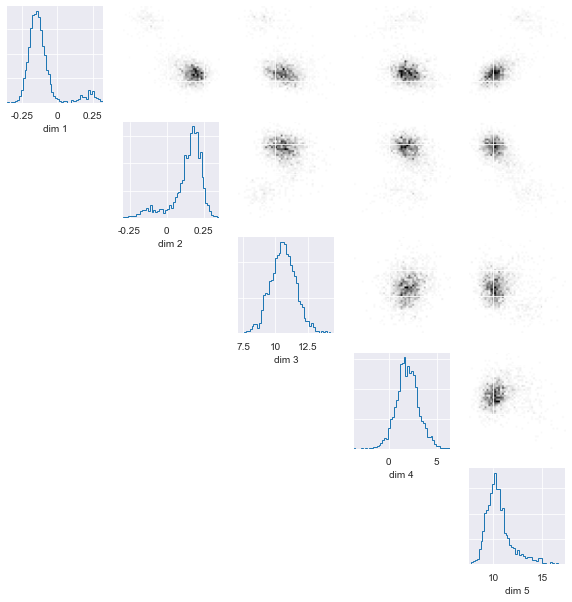

In [26]:
fig, axes = utils.pairplot(samples)
np.savetxt('sbi_samples.txt', np.array(samples))

In [32]:
from tqdm import tqdm
sbi_data = np.genfromtxt('sbi_samples.txt')
sbi_trajs=np.empty((len(sbi_data), ref_traj.shape[0], ref_traj.shape[1], ref_traj.shape[2]))
for i, sample in enumerate(tqdm(sbi_data)):
    start_infected, start_asymptomatic, E_time, A_time, I_time = sample[0], sample[1], sample[2], sample[3], sample[4]
    traj = metapop_wraper(start_infected, start_asymptomatic, E_time, A_time, I_time)
    sbi_trajs[i] = traj

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [18:45<00:00,  1.78it/s]


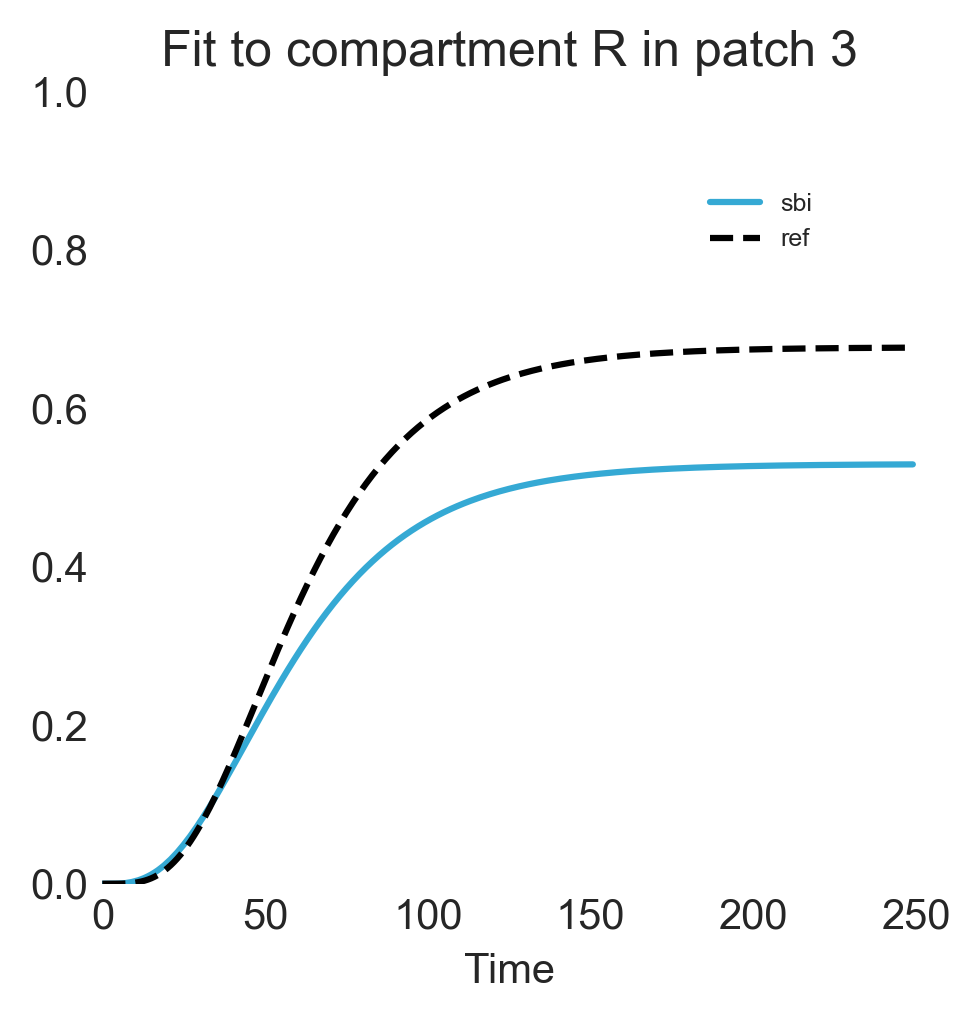

In [40]:
mean_sbi_traj = np.mean(sbi_trajs, axis = 0)
fig, axs = plt.subplots( figsize=(3.5,3.5), dpi =300)
plt.setp(plt.gca(), xlabel='Time', title='Fit to compartment R in patch 3', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
plt.plot(mean_sbi_traj[:,2,4], color= '#35a9d4', label='sbi')
plt.plot(ref_traj[:,2,4],linestyle='--', color= 'k', label='ref')
plt.legend(bbox_to_anchor=(0.9,0.9), fontsize=6)
np.save('mean_sbi_traj',mean_sbi_traj)